# Part 3 ‑ Predictive modeling
Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

In [1]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import numpy
import h2o
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

## 1.Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [2]:
with open('ultimate_data_challenge.json') as logins_file:
    logins_string = json.load(logins_file)
    user_data_df = json_normalize(logins_string)

In [3]:
user_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Two points become evident when looking at the above. Three columns have null values and that signup_date and last_trip_date are not in datetime format. Let's convert signup_date and last_trip_date to datetime format.

In [4]:
user_data_df['signup_date'] = pd.to_datetime(user_data_df['signup_date'])
user_data_df['last_trip_date'] = pd.to_datetime(user_data_df['last_trip_date'])

In [5]:
user_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


Now normally I would say let's deal with the columns with null values. However a couple of weeks ago I attended a meetup where Corinne Horn presented an algorithm called GLRM (Generalized Low Rank Models). In a nutshell this is a model that can be used to reduce the dimensionality of a dataset and help determine which features are important (similar to what PCA does) but your dataset can be heterogeneous (whereas PCA is applied on a data set with numeric variables). Plus with GLRM you don't need to deal with the issue of missing data/null values because model predicts the value of missing data. In other words GLRM among other things does feature engineering, dimentionality reduction and prediction all at the same time. Pretty cool! Now in this part we need to find important features with regard to predicting a certain column in the dataset and the dataset is heterogeneous and contains missing values. So you can imagine this reminded me about the Meetup I attended and I thougt I'd try out GLRM. Finally the paper for GLRM is authored by, among others, Corinne Horn. https://web.stanford.edu/~boyd/papers/pdf/glrm.pdf 

OK, based on the above anecdoe let us not do anything with the null values right now.

For now do NOT replace null values with mean

In [6]:
#user_data_df['avg_rating_of_driver'].fillna(user_data_df['avg_rating_of_driver'].mean(), inplace=True)
#user_data_df['avg_rating_by_driver'].fillna(user_data_df['avg_rating_by_driver'].mean(), inplace=True)
user_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null datetime64[ns]
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


Now we can define the retained column by checking if a user had a trip in the past 30 days. The issue is that the date that the data was pulled is not mentioned so the best we can do is to assume that the date the data was pulled is the same as the last date that a user travelled. Therefore let us look at the last_trip_date column of the dataset 

In [7]:
user_data_df['last_trip_date'].describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

As June is 30 days we will consider a user to be active/retained if that user had a trip in June 2014 or July 2014 ( need to include boundry case 2014-07-01 00:00:00 )

In [8]:
user_data_df['retained'] = user_data_df['last_trip_date'].dt.month >= 6
# print(user_data_df.head())
perc_ret = len(numpy.where(user_data_df['retained'] == True)[0]) / len(user_data_df['retained']) * 100  
print("{0:2f}% of the customers were retained".format(perc_ret))

37.608000% of the customers were retained


## 2.Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

GLRM is packaged in H2O which means we need to start H2O

In [9]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.211-b12, mixed mode)
  Starting server from C:\Users\farbo\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\farbo\AppData\Local\Temp\tmpue_dgexe
  JVM stdout: C:\Users\farbo\AppData\Local\Temp\tmpue_dgexe\h2o_farbo_started_from_python.out
  JVM stderr: C:\Users\farbo\AppData\Local\Temp\tmpue_dgexe\h2o_farbo_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.4
H2O cluster version age:,4 days
H2O cluster name:,H2O_from_python_farbo_ryy015
H2O cluster total nodes:,1
H2O cluster free memory:,1.745 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [10]:
h2o.remove_all()

Let's convert a Pandas dataframe to an H2OFrame and inspect its structure

In [11]:
hf = h2o.H2OFrame(user_data_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [12]:
hf.describe()

Rows:50000
Cols:13




,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
type,enum,int,time,real,real,time,enum,real,enum,real,real,real,enum
mins,,0.0,1388534400000.0,1.0,1.0,1388534400000.0,,0.0,,0.0,0.0,1.0,
mean,,2.278199999999998,1389877460352.002,4.601559291274633,1.0747638000000022,1397894524991.993,,8.849535999999942,,60.92608399999982,5.796826600000038,4.778158195947728,
maxs,,125.0,1391126400000.0,5.0,8.0,1404172800000.0,,100.0,,100.0,160.96,5.0,
sigma,,3.7926840692376356,756364650.5215249,0.6173384560411358,0.2223360089494666,5332520288.309384,,19.958810898131006,,37.081503405105295,5.707356703233388,0.44665179346562056,
zeros,,15390,0,0,0,0,,34409,,9203,150,0,
missing,0,0,0,8122,0,0,0,0,0,0,0,201,0
0,King's Landing,4.0,2014-01-25 00:00:00,4.7,1.1,2014-06-17 00:00:00,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0.0,2014-01-29 00:00:00,5.0,1.0,2014-05-05 00:00:00,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3.0,2014-01-06 00:00:00,4.3,1.0,2014-01-07 00:00:00,iPhone,0.0,False,100.0,0.77,5.0,False


Now let's train the GLRM model. We don't need to set asside separate predictors and responses. We just pass the entire dataset (the labels are just like any other column) to the model and it will predict any missing values in the dataset. Therefore during testing you just need to delete the data in the response column ( i.e. retained ) and send the everything else to the model for inference.

In [13]:
train, test = hf.split_frame(ratios=[0.85], seed=1234)

In [14]:
model = H2OGeneralizedLowRankEstimator(k=6, init="svd", svd_method="power", loss="quadratic"
                                       , regularization_x="l2", regularization_y="l2", max_iterations=2000, gamma_x=2
                                       , gamma_y=1, impute_original=True, score_each_iteration=True, transform="normalize"
                                       , min_step_size=1e-5, loss_by_col=['categorical','categorical','logistic','hinge']
                                       , loss_by_col_idx=[0,6,8,12])

In [15]:
model.train(x=hf.columns, training_frame=train)

glrm Model Build progress: |██████████████████████████████████████████████| 100%


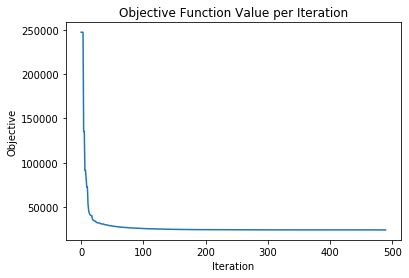

In [16]:
model_score = model.score_history()
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
plt.plot(model_score["iterations"], model_score["objective"])
plt.show()

In [17]:
new_test = h2o.deep_copy(test, 'new_test')
new_test["retained"] = numpy.NaN
pred = model.predict(new_test)
pred['reconstr_retained'] = pred['reconstr_retained'].asfactor()

glrm prediction progress: |███████████████████████████████████████████████| 100%


[[4346  261]
 [ 970 1970]]
0.836888829998675
              precision    recall  f1-score   support

       False       0.82      0.94      0.88      4607
        True       0.88      0.67      0.76      2940

    accuracy                           0.84      7547
   macro avg       0.85      0.81      0.82      7547
weighted avg       0.84      0.84      0.83      7547



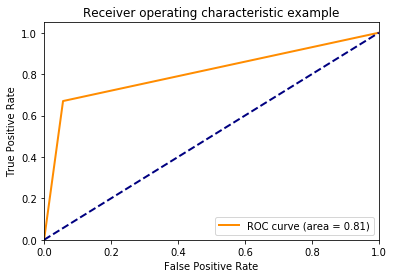

In [18]:
print(confusion_matrix(test.as_data_frame()['retained'], pred.as_data_frame()['reconstr_retained']))
print(accuracy_score(test.as_data_frame()['retained'], pred.as_data_frame()['reconstr_retained']))
print(classification_report(test.as_data_frame()['retained'], pred.as_data_frame()['reconstr_retained']))
fpr, tpr, thresholds = roc_curve(test.as_data_frame()['retained'], pred.as_data_frame()['reconstr_retained'])
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Very good results. Thanks Corrine!

Now we need to figure out what feature are of more importance to the model.

In [19]:
ultimate_y = model._model_json["output"]["archetypes"]
print(ultimate_y)


Archetypes: 

,,cityastapor,citykings_landing,citywinterfell,phone,phoneandroid,phoneiphone,ultimate_black_user,retained,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
0,Arch1,-1.667198,1.473419,-9.656275,-10.558775,14.888120,-13.063803,-15.814348,-9.520181,-0.096356,-0.047193,0.092560,0.066471,-1.528308,0.562040,-4.310270,-0.032060,0.034890
1,Arch2,6.808730,11.477248,-23.416153,-4.601954,-18.807248,14.520443,1.524187,8.372024,0.015606,0.167073,0.169360,0.041162,1.887038,0.425173,-1.609646,-0.046340,0.112630
2,Arch3,25.187413,-1.993286,-12.627748,11.043680,15.178747,-10.030766,9.243775,-6.424874,-0.054100,0.126644,0.117885,-0.013522,-1.933293,-0.129122,1.911734,0.017110,0.103106
3,Arch4,3.861790,-16.502379,0.652950,-14.325537,-13.060579,12.042486,-13.181669,-17.668458,-0.049769,0.007023,-0.018859,-0.019184,-1.840936,-0.213201,2.096625,0.036308,0.019007
4,Arch5,4.940730,1.899691,-0.312369,7.157709,5.001356,1.103934,-31.076436,7.268849,0.006818,0.159078,-0.007974,0.008386,1.208490,0.097396,1.945492,-0.017800,-0.015285
5,Arch6,6.971749,-16.433412,2.353382,-8.985101,-0.957501,-3.455982,3.385795,13.662248,0.086053,0.139820,-0.116636,0.014746,4.112701,0.143410,-1.375277,-0.074614,-0.114025


In [20]:
model._model_json["output"]["importance"]


Importance of components: 

,,pc1,pc2,pc3,pc4,pc5,pc6
0,Standard deviation,1.365848,1.028513,0.788480,0.695770,0.499210,0.370620
1,Proportion of Variance,0.422475,0.239561,0.140792,0.109629,0.056437,0.031107
2,Cumulative Proportion,0.422475,0.662035,0.802827,0.912457,0.968893,1.000000


From the above we can see that the first three principle component ( i.e. Archetypes ) cumulatively explain 80% of the variance of the dataset. Let's look at what features highly contribute positively or negatively to these three Archetypes. 

In [21]:
ultimate_y.as_data_frame().iloc[0,1:].sort_values(ascending=False)

phoneandroid                14.8881
citykings_landing           1.47342
surge_pct                   0.56204
avg_rating_of_driver      0.0925596
avg_surge                 0.0664706
avg_rating_by_driver      0.0348898
avg_dist                 -0.0320599
signup_date              -0.0471926
trips_in_first_30_days    -0.096356
last_trip_date             -1.52831
cityastapor                 -1.6672
weekday_pct                -4.31027
retained                   -9.52018
citywinterfell             -9.65628
phone                      -10.5588
phoneiphone                -13.0638
ultimate_black_user        -15.8143
Name: 0, dtype: object

It appears that being an Ultimate Black customer, type of phone and whether or not the user signed up in winterfell have the highest contribution to Arch1. Whether or not the customer is retained also has high contribution but since we are trying to predict "retained" we cannot use it as a feature for predicting itself.

In [22]:
ultimate_y.as_data_frame().iloc[1,1:].sort_values(ascending=False)

phoneiphone                 14.5204
citykings_landing           11.4772
retained                    8.37202
cityastapor                 6.80873
last_trip_date              1.88704
ultimate_black_user         1.52419
surge_pct                  0.425173
avg_rating_of_driver        0.16936
signup_date                0.167073
avg_rating_by_driver        0.11263
avg_surge                 0.0411619
trips_in_first_30_days    0.0156057
avg_dist                 -0.0463396
weekday_pct                -1.60965
phone                      -4.60195
phoneandroid               -18.8072
citywinterfell             -23.4162
Name: 1, dtype: object

For Arch2 city and phone have the highest contribution

In [23]:
ultimate_y.as_data_frame().iloc[2,1:].sort_values(ascending=False)

cityastapor                 25.1874
phoneandroid                15.1787
phone                       11.0437
ultimate_black_user         9.24378
weekday_pct                 1.91173
signup_date                0.126644
avg_rating_of_driver       0.117885
avg_rating_by_driver       0.103106
avg_dist                    0.01711
avg_surge                -0.0135219
trips_in_first_30_days   -0.0540997
surge_pct                 -0.129122
last_trip_date             -1.93329
citykings_landing          -1.99329
retained                   -6.42487
phoneiphone                -10.0308
citywinterfell             -12.6277
Name: 2, dtype: object

For Arch3 city and phone and being a an Ultimate Black customer

In [24]:
ultimate_y.as_data_frame().iloc[3,1:].sort_values(ascending=False)

phoneiphone                  12.0425
cityastapor                  3.86179
weekday_pct                  2.09663
citywinterfell               0.65295
avg_dist                   0.0363084
avg_rating_by_driver       0.0190074
signup_date               0.00702292
avg_rating_of_driver      -0.0188592
avg_surge                 -0.0191835
trips_in_first_30_days    -0.0497692
surge_pct                  -0.213201
last_trip_date              -1.84094
phoneandroid                -13.0606
ultimate_black_user         -13.1817
phone                       -14.3255
citykings_landing           -16.5024
retained                    -17.6685
Name: 3, dtype: object

In [25]:
ultimate_y.as_data_frame().iloc[4,1:].sort_values(ascending=False)

retained                     7.26885
phone                        7.15771
phoneandroid                 5.00136
cityastapor                  4.94073
weekday_pct                  1.94549
citykings_landing            1.89969
last_trip_date               1.20849
phoneiphone                  1.10393
signup_date                 0.159078
surge_pct                  0.0973961
avg_surge                 0.00838587
trips_in_first_30_days    0.00681802
avg_rating_of_driver      -0.0079745
avg_rating_by_driver      -0.0152847
avg_dist                  -0.0177997
citywinterfell             -0.312369
ultimate_black_user         -31.0764
Name: 4, dtype: object

In [26]:
ultimate_y.as_data_frame().iloc[5,1:].sort_values(ascending=False)

retained                    13.6622
cityastapor                 6.97175
last_trip_date               4.1127
ultimate_black_user          3.3858
citywinterfell              2.35338
surge_pct                   0.14341
signup_date                 0.13982
trips_in_first_30_days    0.0860534
avg_surge                 0.0147464
avg_dist                 -0.0746144
avg_rating_by_driver      -0.114025
avg_rating_of_driver      -0.116636
phoneandroid              -0.957501
weekday_pct                -1.37528
phoneiphone                -3.45598
phone                       -8.9851
citykings_landing          -16.4334
Name: 5, dtype: object

The take away is that based on the above I would use the columns ultimate_black_user, city, phone and maybe weekday_pct to predict whether a customer will be retained in the future.

In [27]:
h2o.cluster().shutdown()

H2O session _sid_a7ef closed.
